In [752]:
from __future__ import print_function
from collections import namedtuple
import os
import torch
import torch.nn as nn
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from src.utils import normalize, setup_dataset
from skimage import color
%matplotlib inline

def convert(dictionary):
    return namedtuple('GenericDict', dictionary.keys())(**dictionary)

In [770]:
# if DATASET=='cifar10':
#     # default params work for cifar
#     pass
# elif DATASET=='celeba':
#     opt.update({      
#              'nz':64, 
#              'dataset': 'celeba',
#              'dataroot': '/sdh/data/celebA/imgs1', # put here your path
#              'image_size':64, 
#             })

# opt['nc'] =  3

torch.cuda.set_device(0)

DATASET = 'colorization'
dtype = torch.FloatTensor
opt=({      
         'nz':16, 
#          'nout':16,
         'dataroot': '/sdh/data/stanford_cars/cropped_scaled_lab_dataset',
#          'dataroot': '/sdh/data/stanford_cars/cropped_scaled_dataset',
         'ngf':64, 
         'ndf': 64, 
         'noise': 'sphere',
         'ngpu': 1,
         'dataset': 'colorization',
         'image_size':64,
         'workers':1,
         'batch_size': 32,
         'nc':3
        })

opt= convert(opt)

# Load g,e
E_path = 'data/checkpoints1/color_cars1/netE_epoch_64.pth'
G_path = 'data/checkpoints1/color_cars1/netG_epoch_64.pth'

# nice reconstructions
E_path = 'data/checkpoints/color_cars3_2/netE_epoch_129.pth'
G_path = 'data/checkpoints/color_cars3_2/netG_epoch_129.pth'

# E_path = 'data/checkpoints/color_cars3_0/netE_epoch_42.pth'
# G_path = 'data/checkpoints/color_cars3_0/netG_epoch_42.pth'

# E_path = 'data/checkpoints/color_cars_ae/netD_epoch_19.pth'
# G_path = 'data/checkpoints/color_cars_ae/netG_epoch_19.pth'

# E_path = 'data/checkpoints/color_cars3_2_unet/netE_epoch_20.pth'
# G_path = 'data/checkpoints/color_cars3_2_unet/netG_epoch_20.pth'

netG = torch.load(G_path).type(dtype)
netE = torch.load(E_path).type(dtype)
    
netG.eval()
netE.eval()

_netE_Base (
  (main): Sequential (
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU (0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (4): LeakyReLU (0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (7): LeakyReLU (0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (10): LeakyReLU (0.2, inplace)
    (11): Conv2d(512, 16, kernel_size=(4, 4), stride=(1, 1))
  )
)


# Sample

In [762]:
def deprocess(tensor):
    if 'colorization' in opt.dataset:
        out = torch.FloatTensor(*tensor.size())

        for i in range(tensor.size(0)):
            this = tensor[i].transpose(0, 2).contiguous().numpy()

            color.colorconv.lab_ref_white = np.array([0.96422, 1.0, 0.82521])

            out[i] = torch.FloatTensor(
                color.lab2rgb(this.astype(np.float64))).transpose(0, 2).contiguous()
        return out
    else:
        return tensor / 2 + 0.5

def conditional(x):
    return x[:, :1, :, :].clone()

In [763]:
dataloader = setup_dataset(opt, train=False)
d = dataloader.next()
x = Variable(d[0], volatile=True)

z = Variable(dtype(opt.batch_size, opt.nz, 1, 1).normal_(0, 1), volatile=True)
z = normalize(z)

samples = netG(conditional(x), z).data.cpu()


grid = torchvision.utils.make_grid(deprocess(samples), pad_value=1)
grid_PIL = transforms.ToPILImage()(grid)

grid_PIL

RuntimeError: inconsistent tensor sizes at /py/conda-bld/pytorch_1493676237139/work/torch/lib/TH/generic/THTensorMath.c:2559

In [470]:
# grid = torchvision.utils.make_grid(d[1], pad_value=1)
# grid_PIL = transforms.ToPILImage()(grid)
# grid_PIL

# Reconstruct

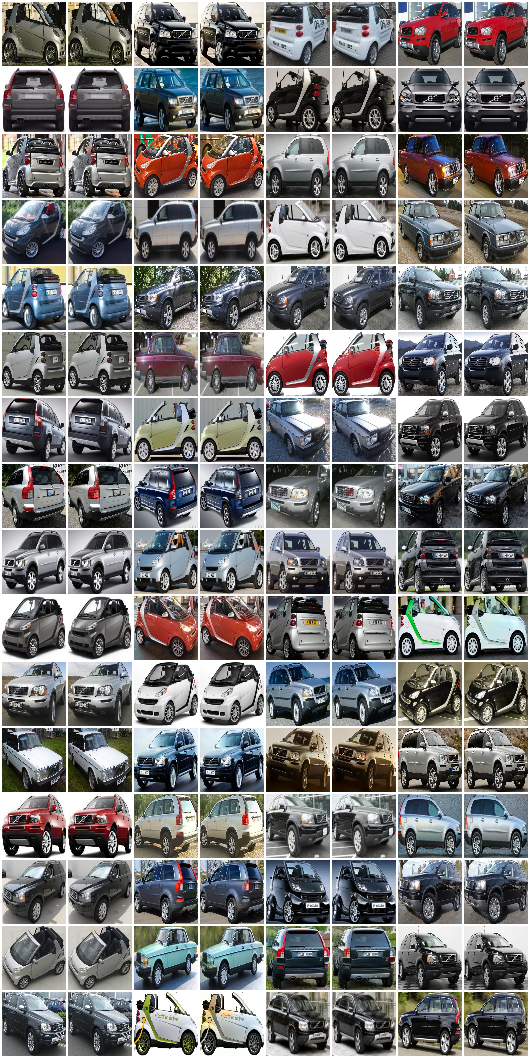

In [693]:
dataloader = setup_dataset(opt, train=False)
d = dataloader.next()

x = Variable(d[0], volatile=True)

ex = netE(x)
gex = netG(conditional(x), ex)


t = torch.FloatTensor(x.size(0) * 2, x.size(1), x.size(2), x.size(3))
t[0::2] = x.data.cpu()[:]
t[1::2] = gex.data.cpu()[:]


grid = torchvision.utils.make_grid(deprocess(t), pad_value=1)
grid_PIL = transforms.ToPILImage()(grid)

grid_PIL

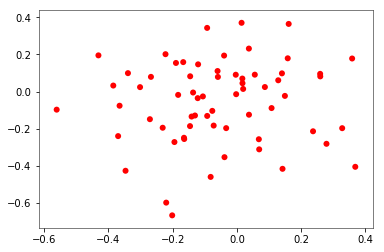

In [534]:
sc2(ex.data.numpy()[:,0],ex.data.numpy()[:,1])

In [437]:
__imp

/home/dulyanov/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/dulyanov/miniconda2/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Color transfer

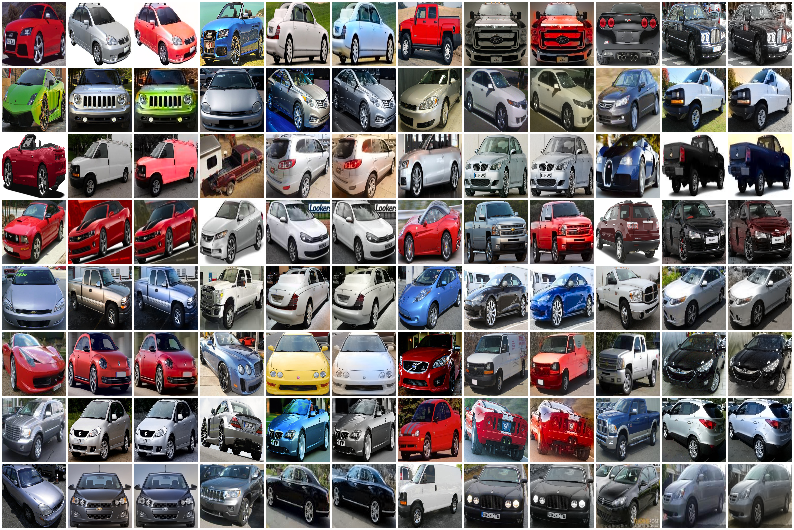

In [781]:
dataloader = setup_dataset(opt, train=True)
d1 = dataloader.next()
x1 = Variable(d1[0], volatile=True)

d2 = dataloader.next()
x2 = Variable(d2[0], volatile=True)

ex1 = netE(x1)
gex = netG(conditional(x2), ex1)


t = torch.FloatTensor(x1.size(0) * 3, x.size(1), x.size(2), x.size(3))
t[0::3] = x1.data.cpu()[:]
t[1::3] = x2.data.cpu()[:]
t[2::3] = gex.data.cpu()[:]


grid = torchvision.utils.make_grid(deprocess(t), pad_value=1,nrow=12)
grid_PIL = transforms.ToPILImage()(grid)

grid_PIL

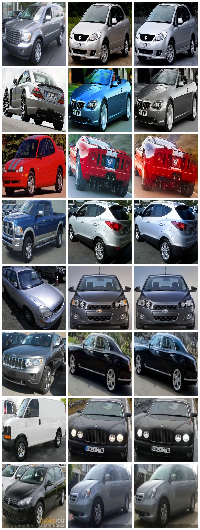

In [784]:
grid = torchvision.utils.make_grid(deprocess(t[8*3*3:]), pad_value=1,nrow=3)
grid_PIL = transforms.ToPILImage()(grid)

grid_PIL

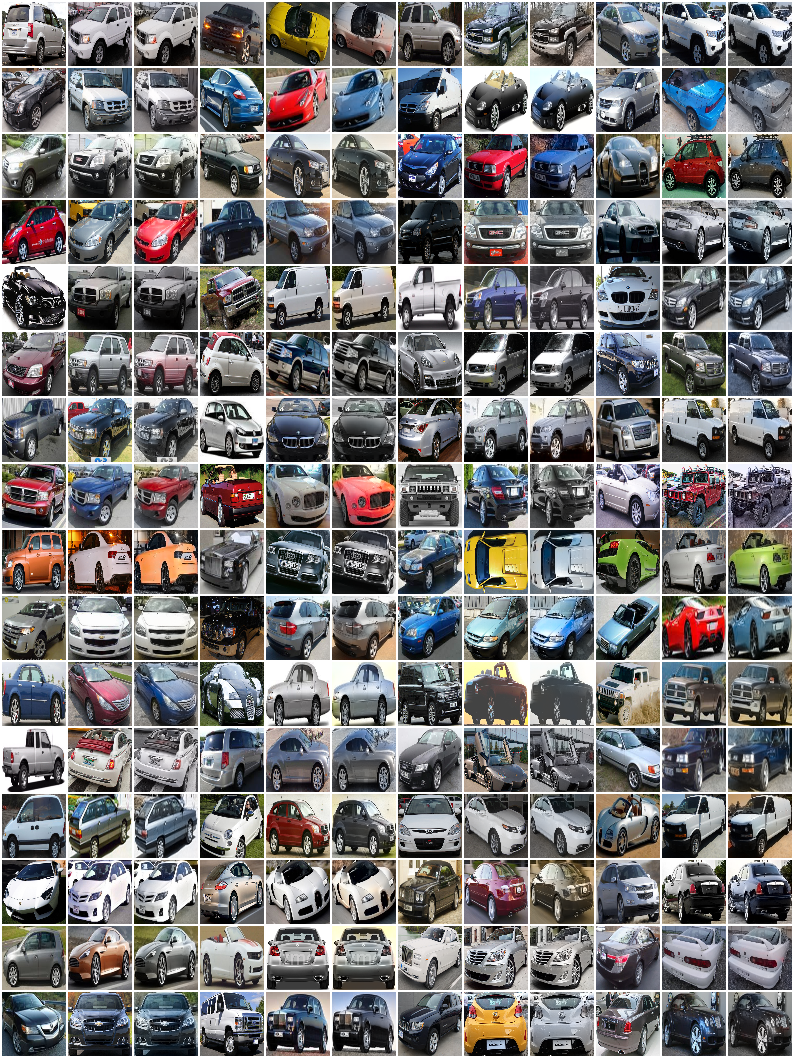

In [758]:
grid = torchvision.utils.make_grid(deprocess(t), pad_value=1,nrow=12)
grid_PIL = transforms.ToPILImage()(grid)

grid_PIL

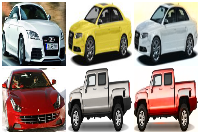

In [719]:
idx = [-19,-2]


grid = torchvision.utils.make_grid(deprocess(torch.cat([t[i*3:i*3+3] for i in idx])), pad_value=1,nrow=3)
grid_PIL = transforms.ToPILImage()(grid)
grid_PIL

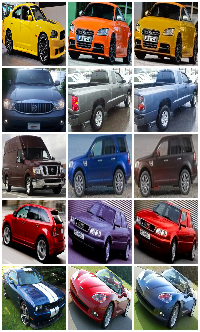

In [718]:
idx1 = [13,23,11,-4,-12]


grid = torchvision.utils.make_grid(deprocess(torch.cat([t1[i*3:i*3+3] for i in idx1])), pad_value=1,nrow=3)
grid_PIL = transforms.ToPILImage()(grid)
grid_PIL

In [720]:
ar1 = [t1[i*3:i*3+3] for i in idx1]
ar = [t[i*3:i*3+3] for i in idx]

In [723]:
for i, f in enumerate(ar + ar1):
    im = transforms.ToPILImage()(deprocess(f)[0])
    im.save('cars_recolor/1/%d.png' % i )
    
    im = transforms.ToPILImage()(deprocess(f)[1])
    im.save('cars_recolor/2/%d.png' % i )
    
    im = transforms.ToPILImage()(deprocess(f)[2])
    im.save('cars_recolor/3/%d.png' % i )

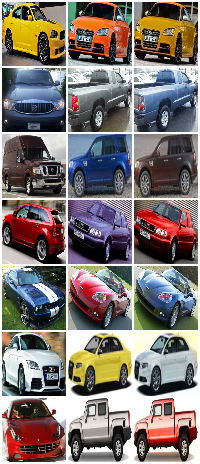

In [726]:
grid = torchvision.utils.make_grid(deprocess(torch.cat(ar1+ar)), pad_value=1,nrow=3)
grid_PIL = transforms.ToPILImage()(grid)
grid_PIL

In [727]:
grid_PIL.save('recolor.png')

In [705]:
t1 = t.clone()

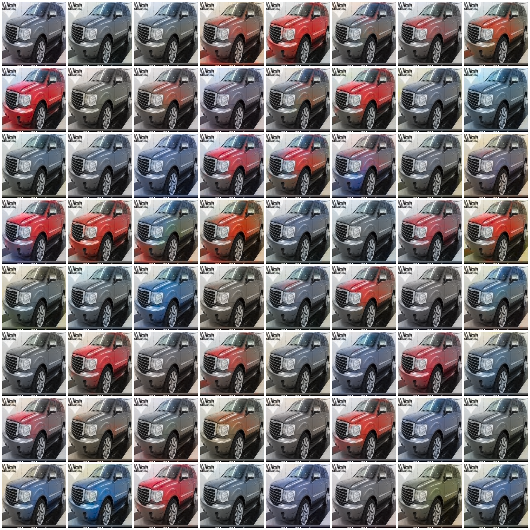

In [535]:
dataloader = setup_dataset(opt, train=True)
d = dataloader.next()
for i in range(1,d[0].size(0)):
    d[0][i] = d[0][0]
x = Variable(d[0], volatile=True)

z = Variable(dtype(opt.batch_size, opt.nz, 1, 1).normal_(0, 1), volatile=True)
z = normalize(z)

samples = netG(conditional(x), z).data.cpu()


grid = torchvision.utils.make_grid(deprocess(samples), pad_value=1)
grid_PIL = transforms.ToPILImage()(grid)

grid_PIL

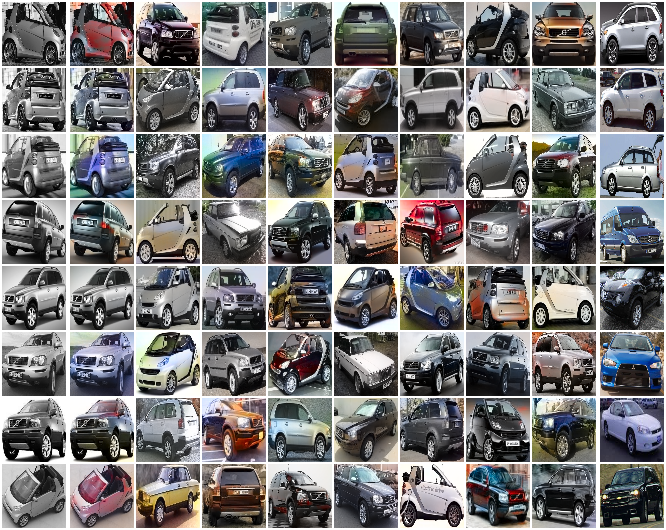

In [748]:
dataloader = setup_dataset(opt, train=True)
d = dataloader.next()
for j in range(0,63,8):
    for i in range(8):
        d[0][j+i] = d[0][j]
        d[1][j+i] = d[1][j]
# x = Variable(d[0], volatile=True)

z = Variable(dtype(opt.batch_size, opt.nz, 1, 1).normal_(0, 1), volatile=True)
z = normalize(z)

c = conditional(x)
samples = netG(c, z).data.cpu()


grid = torchvision.utils.make_grid(deprocess(samples), pad_value=1)


gray = torchvision.utils.make_grid(c.data.cpu()[::8]/100, pad_value=1, nrow=1)
gt = torchvision.utils.make_grid(d[1][::8], pad_value=1, nrow=1)

grid = torch.cat([gray, grid, gt], dim=2)

grid_PIL = transforms.ToPILImage()(grid)

grid_PIL

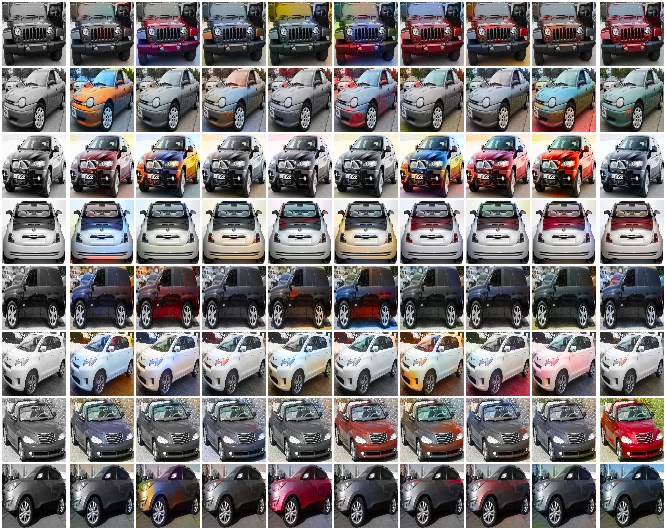

In [750]:
dataloader = setup_dataset(opt, train=True)
d = dataloader.next()
for j in range(0,63,8):
    for i in range(8):
        d[0][j+i] = d[0][j]
        d[1][j+i] = d[1][j]
x = Variable(d[0], volatile=True)

z = Variable(dtype(opt.batch_size, opt.nz, 1, 1).normal_(0, 1), volatile=True)
z = normalize(z)

c = conditional(x)
samples = netG(c, z).data.cpu()


grid = torchvision.utils.make_grid(deprocess(samples), pad_value=1)


gray = torchvision.utils.make_grid(c.data.cpu()[::8]/100, pad_value=1, nrow=1)
gt = torchvision.utils.make_grid(d[1][::8], pad_value=1, nrow=1)

grid = torch.cat([gray, grid, gt], dim=2)

grid_PIL = transforms.ToPILImage()(grid)

grid_PIL

# Colorize

In [751]:
from PIL import Image
def get_images():

    imgs = []
    for i in range(8):
        img = np.array(Image.open('cars/%d.png' % i).convert('RGB'))

        imgs.append(img)

    imgs = np.array(imgs)
#     print imgs.shape

    return imgs.transpose(0, 3, 1, 2).astype(np.float32) / 255

imgs = get_images()*2-1

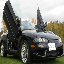

In [591]:
transforms.ToPILImage()(deprocess(x.data)[18])

In [592]:
cc = transforms.ToPILImage()(deprocess(x.data)[18])

In [593]:
cc.save('cars/8.png')

In [541]:
d[0].size()

torch.Size([64, 3, 64, 64])

In [744]:
import torchvision
from PIL import Image
def load(path):
    return torchvision.transforms.ToTensor()(Image.open(path).convert('RGB'))[None,...]

st = ''
stacks = []
for i in range(8):
    orig = load(st + 'cars/%d.png' %i)
    gray = orig
    
    ours = []
    for j in range(6):
#         ours.append(load(st + 'cars/%d_%d.png' % (i,j)))
        ours.append(load(st + 'cars/%d.png' %i))
    
    pix2pix = []
    for j in range(6):
#         ours.append(load(st + 'cars/%d_%d.png' % (i,j)))
        pix2pix.append(load(st + 'cars/%d.png' %i))
    
#     ali_full = load(st + 'ali_full/%d.png' %i)
#     ali_10 = load(st + 'ali_10/%d.png' %i)
#     vae = load(st + 'autoencoder/%d.png' %i)
    
    _all = [orig]
    _all.extend(ours)
    _all.extend(pix2pix)
    
    ours_stack = torch.cat(ours)
    ours_stack = make_grid(ours_stack)[None,:,2:-2]
    
    print(ours_stack.size())
    
    pix2pix_stack = torch.cat(pix2pix)
    pix2pix_stack = make_grid(pix2pix_stack)[None,:,2:-2]
    
    print(pix2pix_stack.size())
    
    right_stack = torch.cat([ours_stack, pix2pix_stack])
    right_stack = make_grid(right_stack, nrow=1)[None,...]
    print(right_stack.size())
    
    left_stack = torch.cat([orig, gray])
    left_stack =  make_grid(left_stack,nrow=1)[None,:,:,2:-2]
    print(left_stack.size())
    
    dd = torch.ones([1,3,134,5])
    stack = torch.cat([left_stack, dd, right_stack],dim=3)
#     stack =  make_grid(stack,nrow=2)[None,...]
#     ours_stack = torch.cat([orig, ours])
#     pix_stack = torch.cat([orig, ours])
    
#     stack = torch.cat([orig, ours, ali_10, ali_full, vae])
    stacks.append(stack)


torch.Size([1, 3, 64, 398])
torch.Size([1, 3, 64, 398])
torch.Size([1, 3, 134, 402])
torch.Size([1, 3, 134, 64])
torch.Size([1, 3, 64, 398])
torch.Size([1, 3, 64, 398])
torch.Size([1, 3, 134, 402])
torch.Size([1, 3, 134, 64])
torch.Size([1, 3, 64, 398])
torch.Size([1, 3, 64, 398])
torch.Size([1, 3, 134, 402])
torch.Size([1, 3, 134, 64])
torch.Size([1, 3, 64, 398])
torch.Size([1, 3, 64, 398])
torch.Size([1, 3, 134, 402])
torch.Size([1, 3, 134, 64])
torch.Size([1, 3, 64, 398])
torch.Size([1, 3, 64, 398])
torch.Size([1, 3, 134, 402])
torch.Size([1, 3, 134, 64])
torch.Size([1, 3, 64, 398])
torch.Size([1, 3, 64, 398])
torch.Size([1, 3, 134, 402])
torch.Size([1, 3, 134, 64])
torch.Size([1, 3, 64, 398])
torch.Size([1, 3, 64, 398])
torch.Size([1, 3, 134, 402])
torch.Size([1, 3, 134, 64])
torch.Size([1, 3, 64, 398])
torch.Size([1, 3, 64, 398])
torch.Size([1, 3, 134, 402])
torch.Size([1, 3, 134, 64])


In [734]:
left_stack.size()

torch.Size([1, 3, 134, 64])

In [745]:
N=4
torchvision.utils.save_image(make_grid(torch.cat(stacks), nrow = 2, padding=10, paddingh=5)[:,N:-N,4:-10], 'cars_comparison_2.png')

In [615]:
import torch
import math
irange = range


def make_grid(tensor, nrow=8, padding=2, paddingh=2,
              normalize=False, range=None, scale_each=False):
    """
    Given a 4D mini-batch Tensor of shape (B x C x H x W),
    or a list of images all of the same size,
    makes a grid of images of size (B / nrow, nrow).
    normalize=True will shift the image to the range (0, 1),
    by subtracting the minimum and dividing by the maximum pixel value.
    if range=(min, max) where min and max are numbers, then these numbers are used to
    normalize the image.
    scale_each=True will scale each image in the batch of images separately rather than
    computing the (min, max) over all images.
    [Example usage is given in this notebook](https://gist.github.com/anonymous/bf16430f7750c023141c562f3e9f2a91)
    """
    # if list of tensors, convert to a 4D mini-batch Tensor
    if isinstance(tensor, list):
        tensorlist = tensor
        numImages = len(tensorlist)
        size = torch.Size(torch.Size([numImages]) + tensorlist[0].size())
        tensor = tensorlist[0].new(size)
        for i in irange(numImages):
            tensor[i].copy_(tensorlist[i])

    if tensor.dim() == 2:  # single image H x W
        tensor = tensor.view(1, tensor.size(0), tensor.size(1))
    if tensor.dim() == 3:  # single image
        if tensor.size(0) == 1:  # if single-channel, convert to 3-channel
            tensor = torch.cat((tensor, tensor, tensor), 0)
        return tensor
    if tensor.dim() == 4 and tensor.size(1) == 1:  # single-channel images
        tensor = torch.cat((tensor, tensor, tensor), 1)

    if normalize is True:
        if range is not None:
            assert isinstance(range, tuple), \
                "range has to be a tuple (min, max) if specified. min and max are numbers"

        def norm_ip(img, min, max):
            img.clamp_(min=min, max=max)
            img.add_(-min).div_(max - min)

        def norm_range(t, range):
            if range is not None:
                norm_ip(t, range[0], range[1])
            else:
                norm_ip(t, t.min(), t.max())

        if scale_each is True:
            for t in tensor:  # loop over mini-batch dimension
                norm_range(t, range)
        else:
            norm_range(tensor, range)

#     paddingh = 0
    # make the mini-batch of images into a grid
    nmaps = tensor.size(0)
    xmaps = min(nrow, nmaps)
    ymaps = int(math.ceil(float(nmaps) / xmaps))
    height, width = int(tensor.size(2) + paddingh), int(tensor.size(3) + padding)
    grid = tensor.new(3, height * ymaps + 1 + paddingh // 2, width * xmaps + 1 + padding // 2).fill_(1)
    k = 0
    for y in irange(ymaps):
        for x in irange(xmaps):
            if k >= nmaps:
                break
            grid.narrow(1, y * height + 1 + paddingh // 2, height - paddingh)\
                .narrow(2, x * width + 1 + padding // 2, width - padding)\
                .copy_(tensor[k])
            k = k + 1
    return grid

In [340]:
ex = netE(x)
gex = netG(conditional(x), ex)


0.0
0.142857142857
0.285714285714
0.428571428571
0.571428571429
0.714285714286
0.857142857143
1.0


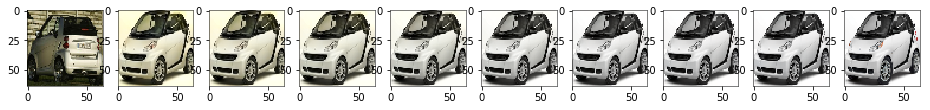

In [502]:
#### N = 8
N=8
f, axarr = plt.subplots(1, N+2, figsize = (16,4))

# k1=39
# k2 = 19

k1=42
k2 = -30

input = x
ex = netE(x)

x1 = input[k1:k1+1]
x2 = input[k2:k2+1]

axarr[-1].imshow(deprocess(x1.data)[0].numpy().transpose(1,2,0))
axarr[0].imshow(deprocess(x2.data)[0].numpy().transpose(1,2,0))

imgs = [input[k2:k2+1].data.numpy()]
for i in range(N):
    print(float(i)/(N-1))
    w= 0
    n = normalize(ex[k1:k1+1]*(float(i)/(N-1)) + ex[k2:k2+1]*(1-float(i)/(N-1)))
    o = netG(conditional(x1)*w+(1-w)*conditional(x1),n.view(n.size(0),n.size(1),1,1))
    
    axarr[i+1].imshow(deprocess(o.data)[0].numpy().transpose(1,2,0))
    
    imgs.append(o.data.numpy())
    
imgs.append(x1.data.numpy())
# imgs
plt.show()

In [354]:
deprocess(x1.data).size()

torch.Size([1, 3, 64, 64])

In [343]:
x1.size()

torch.Size([3, 64, 64])